In [3]:
!pip install -U "tensorflow-text==2.13.0rc0"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/email.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [3]:
df.groupby('Category').describe()

Message         \
                 count unique   
Category                        
ham               4825   4516   
spam               747    641   
{"mode":"full"       1      1   

                                                                        
                                                              top freq  
Category                                                                
ham                                        Sorry, I'll call later   30  
spam            Please call our customer service representativ...    4  
{"mode":"full"                                    isActive:false}    1

There is imbalanced dataset so now I will be taking same number of spam as well as ham count.

##Downsampling

In [4]:
df_spam=df[df['Category']=='spam']
df_ham=df[df['Category']=='ham']

In [5]:
df_spam.shape,df_ham.shape

((747, 2), (4825, 2))

In [6]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [7]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [8]:
df_balanced['Category'].value_counts()

,count
Category,
spam,747
ham,747


In [9]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.head()

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [11]:
X_train.head(5)

,Message
364,Busy here. Trying to finish for new year. I am...
3409,Do you want a New Nokia 3510i colour phone Del...
2705,FreeMsg: Fancy a flirt? Reply DATE now & join ...
569,Love it! Daddy will make you scream with pleas...
2615,"Sir, hope your day is going smoothly. i really..."


In [12]:
bert_preprocess=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
def get_sentence_embeding(sentences):
    preprocessed_text=bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
e=get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [16]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.760692  , -0.14219385,  0.49604586, ...,  0.42165312,
        -0.532214  ,  0.8031219 ],
       [-0.86023223, -0.2124296 ,  0.49156848, ...,  0.39797997,
        -0.60506296,  0.8447167 ],
       [-0.7128862 , -0.15463911,  0.384017  , ...,  0.3527875 ,
        -0.5099134 ,  0.734741  ],
       [-0.82533467, -0.35550597, -0.5906975 , ..., -0.01613778,
        -0.61417586,  0.8723029 ],
       [-0.75041336, -0.2681262 , -0.26689708, ...,  0.02839353,
        -0.5938098 ,  0.7974988 ],
       [-0.78544426, -0.2994976 ,  0.41027158, ...,  0.52225286,
        -0.49573594,  0.8150757 ]], dtype=float32)>

In [17]:
#"banana","grapes",
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [18]:
#"banana", "jeff bezos",
cosine_similarity([e[0]],[e[3]])

array([[0.84703827]], dtype=float32)

In [19]:
#Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#Neural network layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

# Construct final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [20]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [21]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [22]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 442s 12s/step - loss: 0.6627 - accuracy: 0.6045 - precision: 0.6149 - recall: 0.5589
Epoch 2/10
35/35 [==============================] - 431s 12s/step - loss: 0.5407 - accuracy: 0.7884 - precision: 0.7761 - recall: 0.8107
Epoch 3/10
35/35 [==============================] - 592s 17s/step - loss: 0.4619 - accuracy: 0.8429 - precision: 0.8322 - recall: 0.8589
Epoch 4/10
35/35 [==============================] - 432s 12s/step - loss: 0.4153 - accuracy: 0.8545 - precision: 0.8417 - recall: 0.8732
Epoch 5/10
35/35 [==============================] - 432s 12s/step - loss: 0.3836 - accuracy: 0.8732 - precision: 0.8616 - recall: 0.8893
Epoch 6/10
35/35 [==============================] - 435s 12s/step - loss: 0.3513 - accuracy: 0.8893 - precision: 0.8720 - recall: 0.9125
Epoch 7/10
35/35 [==============================] - 433s 12s/step - loss: 0.3299 - accuracy: 0.8884 - precision: 0.8769 - recall: 0.9036
Epoch 8/10
35/35 [=======================

In [23]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 146s 12s/step - loss: 0.2635 - accuracy: 0.9198 - precision: 0.8867 - recall: 0.9626


[0.2634800970554352,
 0.9197860956192017,
 0.8866994976997375,
 0.9625668525695801]

In [24]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()

12/12 [==============================] - 145s 12s/step


In [25]:
import numpy as np
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_test,y_predicted)
cm

array([[164,  23],
       [  7, 180]])

Text(50.722222222222214, 0.5, 'Truth')

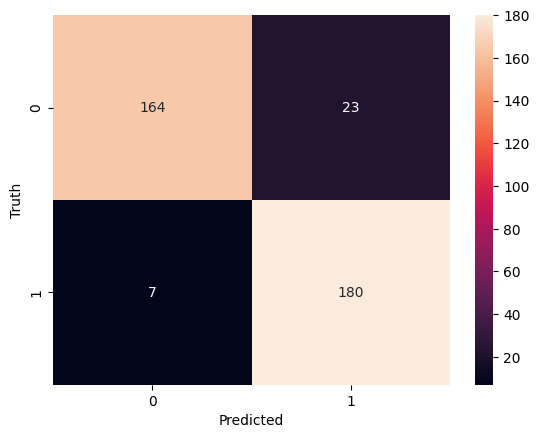

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       187
           1       0.89      0.96      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [29]:
reviews=[
    'Reply to win $100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to',
    'Why are you waiting for me',
    'Next meal is free go and eat at AL BAZZAR'

]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.8131589 ],
       [0.01769179],
       [0.7805835 ]], dtype=float32)

In [30]:
model.save('/content/drive/My Drive//Colab Notebooks/model.h5')



/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
